In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys, os, django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "kocherga.django.settings")
django.setup()

import django.db

In [13]:
from kocherga.cm.models import Order

In [15]:
df = pd.read_sql_query(str(Order.objects.all().query), django.db.connection)

In [16]:
df.head(2)

,order_id,card_id,start_ts,end_ts,imported_ts,log_imported_ts,people,visit_length,full_visit_length,order_value,time_value,stuff_value,payment_type,is_fixed,client_name,manager,tariff_time,tariff_plan,comment,history
0,1,1,1442677680,1442682300,1550367096,NaN,1,76,76,152,152,0,Нал,нет,,Anny,Включен,,,"Открыт заказ, Заказ закрыт."
1,2,3,1442823780,1442829480,1550367096,NaN,1,95,95,190,190,0,Нал,нет,Лях,admin,Включен,,,"Открыт заказ, Заказ закрыт."


In [17]:
df['start'] = pd.to_datetime(df['start_ts'], unit='s')

In [18]:
df['start'].head(3)

0   2015-09-19 15:48:00
1   2015-09-21 08:23:00
2   2015-09-21 14:45:00
Name: start, dtype: datetime64[ns]

In [19]:
df['period'] = df['start'].apply(lambda x: x.strftime('%Y-%m'))

In [20]:
df['period'].head(3)

0    2015-09
1    2015-09
2    2015-09
Name: period, dtype: object

In [21]:
df = df[df['client_name'] != '']

In [22]:
df2 = df.reindex(columns=['order_id', 'card_id', 'start', 'period', 'people', 'visit_length', 'order_value', 'time_value'])

In [23]:
df2.set_index('card_id', inplace=True)
df2['CohortGroup'] = df2.groupby(level=0)['start'].min().apply(lambda x: x.strftime('%Y-%m'))
df2.reset_index(inplace=True)

In [24]:
df2.head(3)

,card_id,order_id,start,period,people,visit_length,order_value,time_value,CohortGroup
0,3,2,2015-09-21 08:23:00,2015-09,1,95,190,190,2015-09
1,4,9,2015-09-22 17:27:00,2015-09,1,110,220,220,2015-09
2,5,10,2015-09-22 18:26:00,2015-09,1,79,158,158,2015-09


In [25]:
grouped = df2.groupby(['CohortGroup', 'period'])

In [26]:
cohorts = grouped.agg({'card_id': pd.Series.nunique, 'order_id': pd.Series.nunique, 'order_value': np.sum})
cohorts = cohorts.rename(columns={'card_id': 'total_users', 'order_id': 'total_orders', 'order_value': 'total_income'})

In [27]:
cohorts.tail(21)

total_users  total_orders  total_income
CohortGroup period                                          
2018-09     2018-09           56           133         44345
            2018-10           31           135         28160
            2018-11           17            83         14074
            2018-12           14            56          7890
            2019-01            9            54          7860
            2019-02           11            39          4140
2018-10     2018-10           74           153         43947
            2018-11           24           119         19936
            2018-12           16            84         10810
            2019-01           16            55          7730
            2019-02           13            42          6230
2018-11     2018-11           39            61         17100
            2018-12           14            57          5660
            2019-01            6            26          3160
            2019-02            6            17          1730
2018-12     2018-12           33            55         21040
            2019-01            8            13          4730
            2019-02            4            11          2610
2019-01     2019-01           51            95         38141
            2019-02           14            28          8138
2019-02     2019-02           26            41         12702

In [28]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [29]:
cohorts.tail(21)

total_users  total_orders  total_income  CohortPeriod
CohortGroup period                                                        
2018-09     2018-09           56           133         44345             1
            2018-10           31           135         28160             2
            2018-11           17            83         14074             3
            2018-12           14            56          7890             4
            2019-01            9            54          7860             5
            2019-02           11            39          4140             6
2018-10     2018-10           74           153         43947             1
            2018-11           24           119         19936             2
            2018-12           16            84         10810             3
            2019-01           16            55          7730             4
            2019-02           13            42          6230             5
2018-11     2018-11           39            61         17100             1
            2018-12           14            57          5660             2
            2019-01            6            26          3160             3
            2019-02            6            17          1730             4
2018-12     2018-12           33            55         21040             1
            2019-01            8            13          4730             2
            2019-02            4            11          2610             3
2019-01     2019-01           51            95         38141             1
            2019-02           14            28          8138             2
2019-02     2019-02           26            41         12702             1

In [30]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
cohort_group_size = cohorts['total_users'].groupby(level=0).first()

In [31]:
cohort_group_size.tail(6)

CohortGroup
2018-09    56
2018-10    74
2018-11    39
2018-12    33
2019-01    51
2019-02    26
Name: total_users, dtype: int64

In [32]:
cohorts.tail(21)

period  total_users  total_orders  total_income
CohortGroup CohortPeriod                                                  
2018-09     1             2018-09           56           133         44345
            2             2018-10           31           135         28160
            3             2018-11           17            83         14074
            4             2018-12           14            56          7890
            5             2019-01            9            54          7860
            6             2019-02           11            39          4140
2018-10     1             2018-10           74           153         43947
            2             2018-11           24           119         19936
            3             2018-12           16            84         10810
            4             2019-01           16            55          7730
            5             2019-02           13            42          6230
2018-11     1             2018-11           39            61         17100
            2             2018-12           14            57          5660
            3             2019-01            6            26          3160
            4             2019-02            6            17          1730
2018-12     1             2018-12           33            55         21040
            2             2019-01            8            13          4730
            3             2019-02            4            11          2610
2019-01     1             2019-01           51            95         38141
            2             2019-02           14            28          8138
2019-02     1             2019-02           26            41         12702

In [33]:
user_retention_percentage = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
orders_retention_percentage = cohorts['total_orders'].unstack(0).divide(cohort_group_size, axis=1)
user_retention = cohorts['total_users'].unstack(0)
orders_retention = cohorts['total_orders'].unstack(0)
income_retention = cohorts['total_income'].unstack(0)

Text(0, 0.5, '% of Cohort Purchasing')

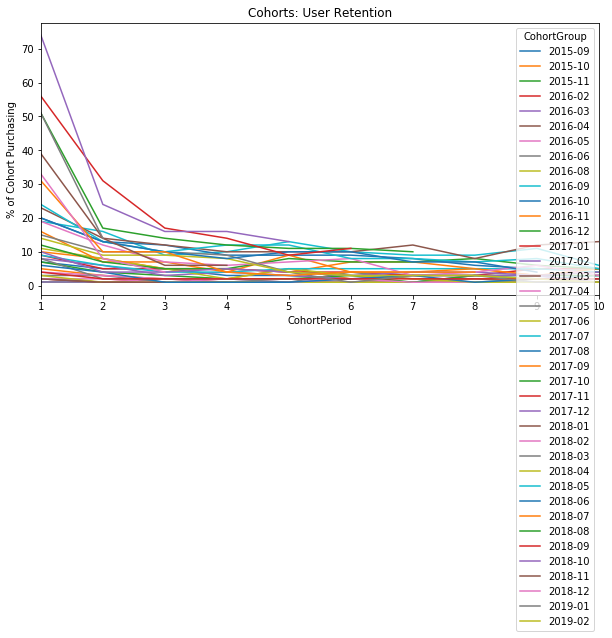

In [34]:
user_retention.head(10).plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 50., 1))
plt.xlim(1, 10)
plt.ylabel('% of Cohort Purchasing')

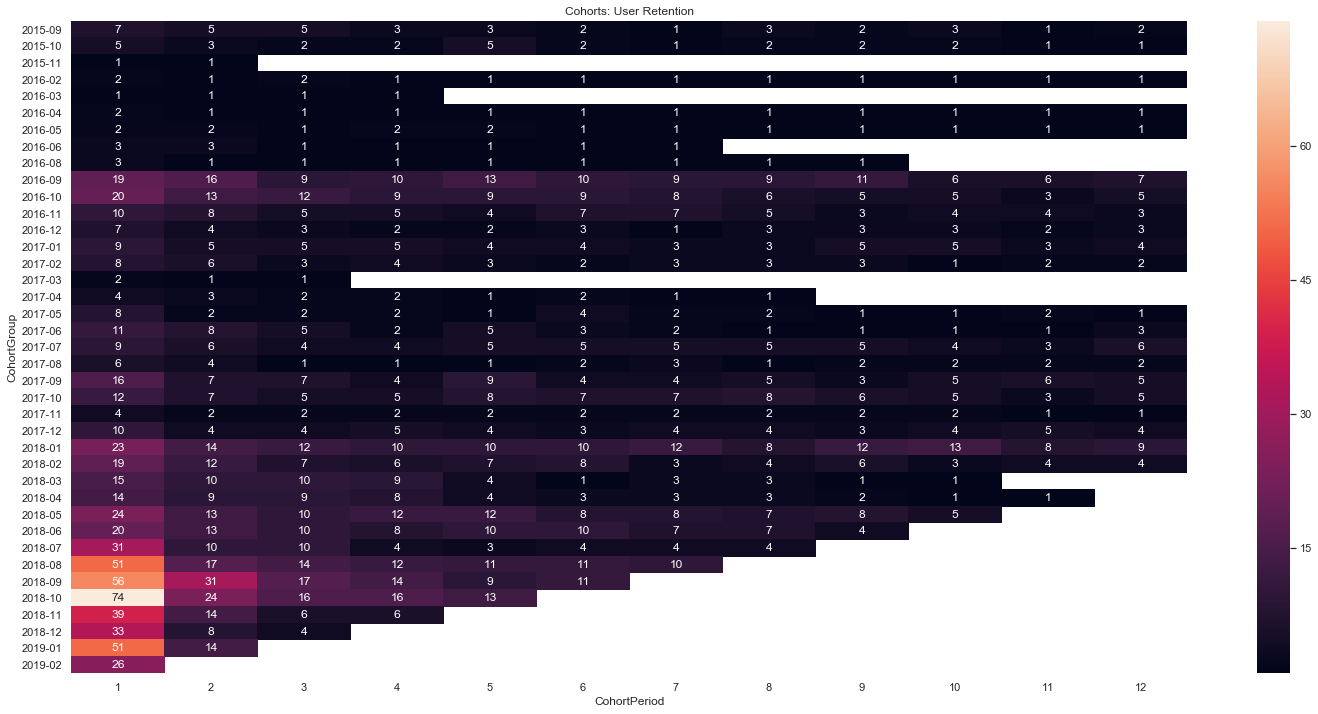

In [35]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(25, 12))
plt.title('Cohorts: User Retention')
# sns.heatmap(user_retention.head(10).T, mask=user_retention.head(10).T.isnull(), annot=True, fmt='.0%')
# sns.heatmap(orders_retention_percentage.head(10).T, mask=user_retention_percentage.head(10).T.isnull(), annot=True, fmt='.0%')
sns.heatmap(user_retention.head(12).T, mask=user_retention_percentage.head(12).T.isnull(), annot=True, fmt='.0f')